Using device: mps
Found 20580 images across 120 classes
Found 20580 images across 120 classes
Found 20580 images across 120 classes


/Users/juandisay/.pyenv/versions/3.8.13/envs/+Ai/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training Configuration:
Number of classes: 120
Total images: 20580
Training images: 16464
Validation images: 4116
Batch size: 16
Learning rate: 0.001
Number of epochs: 10
Device: mps
Epoch [1/10], Step [10/1029], Loss: 6.1160
Epoch [1/10], Step [20/1029], Loss: 4.8377
Epoch [1/10], Step [30/1029], Loss: 4.5511
Epoch [1/10], Step [40/1029], Loss: 4.3697
Epoch [1/10], Step [50/1029], Loss: 4.1380
Epoch [1/10], Step [60/1029], Loss: 3.5522
Epoch [1/10], Step [70/1029], Loss: 3.0179
Epoch [1/10], Step [80/1029], Loss: 3.2304
Epoch [1/10], Step [90/1029], Loss: 3.2290
Epoch [1/10], Step [100/1029], Loss: 2.6129
Epoch [1/10], Step [110/1029], Loss: 2.8721
Epoch [1/10], Step [120/1029], Loss: 2.8122
Epoch [1/10], Step [130/1029], Loss: 2.3366
Epoch [1/10], Step [140/1029], Loss: 2.5569
Epoch [1/10], Step [150/1029], Loss: 2.1814
Epoch [1/10], Step [160/1029], Loss: 2.4044
Epoch [1/10], Step [170/1029], Loss: 2.6363
Epoch [1/10], Step [180/1029], Loss: 2.8030
Epoch [1/10], Step [190/1029], Lo

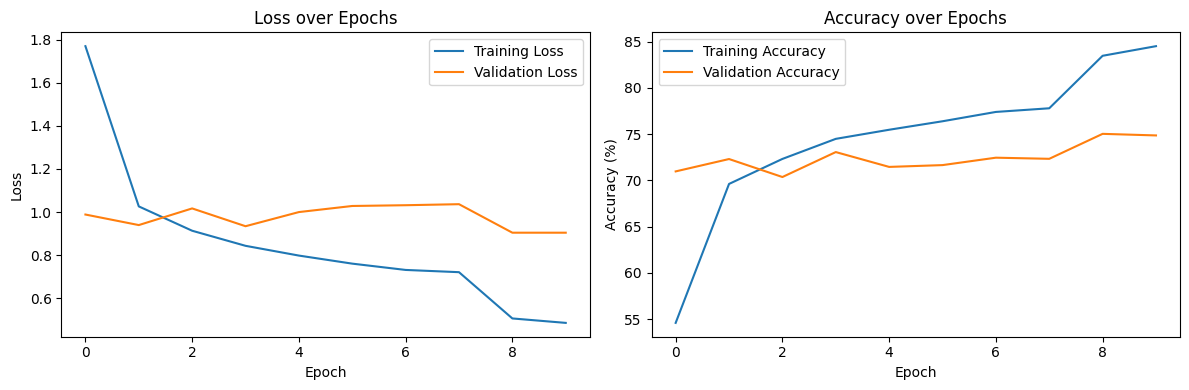

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import torch.optim as optim

class DogDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.transform = transform
        
        self.data_pairs = []
        self.classes = []
        
        # Get all class directories
        self.classes = [d.name for d in self.image_dir.iterdir() if d.is_dir() and not d.name.startswith('.')]
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(self.classes))}
        
        # Collect all images
        for class_name in self.classes:
            img_class_dir = self.image_dir / class_name
            
            if img_class_dir.exists():
                for img_path in img_class_dir.glob('*.jpg'):
                    self.data_pairs.append({
                        'image': img_path,
                        'class': class_name
                    })
        
        if len(self.data_pairs) == 0:
            print("Warning: No images found!")
        else:
            print(f"Found {len(self.data_pairs)} images across {len(self.classes)} classes")
    
    def __len__(self):
        return len(self.data_pairs)
    
    def __getitem__(self, idx):
        data_pair = self.data_pairs[idx]
        
        # Load image
        image = Image.open(data_pair['image']).convert('RGB')
        
        # Get class label
        label = self.class_to_idx[data_pair['class']]
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            
        return image, label

class DogClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DogClassifier, self).__init__()
        # Using MobileNetV2 for better performance on M1
        self.model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        # Freeze base layers
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Modify classifier
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.model.last_channel, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    return train_losses, train_accs, val_losses, val_accs

# Configuration
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
IMAGE_SIZE = 224

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Setup device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Setup dataset
dataset_path = Path('dataset/images')  # Adjust this path to your dataset location
full_dataset = DogDataset(dataset_path, transform=None)

# Split indices for train/val
train_idx, val_idx = train_test_split(
    range(len(full_dataset)),
    test_size=0.2,
    random_state=42,
    stratify=[pair['class'] for pair in full_dataset.data_pairs]
)

# Create train and validation datasets
train_dataset = DogDataset(dataset_path, transform=train_transform)
train_dataset.data_pairs = [full_dataset.data_pairs[i] for i in train_idx]
train_dataset.classes = full_dataset.classes
train_dataset.class_to_idx = full_dataset.class_to_idx

val_dataset = DogDataset(dataset_path, transform=val_transform)
val_dataset.data_pairs = [full_dataset.data_pairs[i] for i in val_idx]
val_dataset.classes = full_dataset.classes
val_dataset.class_to_idx = full_dataset.class_to_idx

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Important for M1 compatibility
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0  # Important for M1 compatibility
)

# Initialize model
model = DogClassifier(len(full_dataset.classes)).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    verbose=True
)

# Print training configuration
print(f"\nTraining Configuration:")
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Device: {device}")

# Start training
train_losses, train_accs, val_losses, val_accs = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    NUM_EPOCHS,
    device
)

# Plot results
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()